## wgMLST for mbovis

* http://www3.ridom.de/seqsphere/cgmlst/
* https://www.cgmlst.org/ncs/schema/741110/
* https://jcm.asm.org/content/52/7/2479
* https://www.biorxiv.org/content/10.1101/172858v1.full
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3980634/

## steps

* get MLST gene list
* assembly
* annotate
* assign allele numbers?

In [48]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)
import pylab as plt
import seaborn as sns
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from io import StringIO
import snipgenie as snpg
import pathogenie as pg
import toytree

In [807]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')
vcf_file='/storage/btbgenie/wicklow_results/snps.vcf.gz'

In [ ]:
def get_samples_vcf(vcf_file):
    cmd = 'bcftools query -l %s' %vcf_file
    tmp = subprocess.check_output(cmd, shell=True)
    return tmp.decode().split('\n')
    
samplenames = get_samples_vcf(vcf_file)
samplenames

In [802]:
path = '/storage/btbgenie/mbovis_ireland/Wicklow/'
files = glob.glob(os.path.join(path,'**', '*.fastq.gz'),recursive=True)
samp = snpg.app.get_samples(files,sep='_')
pairs = pd.pivot_table(samp,index=['sample'],columns=['pair'],values='filename',aggfunc='first').reset_index()
print (pairs[:2])

pair    sample                                                                                             1  \
0         1034                  /storage/btbgenie/mbovis_ireland/Wicklow/dog/1034_S91_L001-4_R2_001.fastq.gz   
1     13-11594  /storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_15-03-19/13-11594_S85_L001-4_R1_001.fastq.gz   

pair                                                                                             2  
0                     /storage/btbgenie/mbovis_ireland/Wicklow/dog/1034_S91_L001-4_R1_001.fastq.gz  
1     /storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_15-03-19/13-11594_S85_L001-4_R2_001.fastq.gz  


## create reference proteins for MLST

In [ ]:
prots = pg.tools.genbank_to_dataframe('Mbovis-AF212297.2.gb',cds=True)
prots = prots.fillna('')
prots = prots.dropna(subset=['locus_tag'])
ref_proteins = 'Mbovis_AF212297_proteins.fa'
#get prokka type header for using in annotation
prots['header'] = prots.apply(lambda x: '~~~'.join([x.locus_tag,x.gene,x['product'],'none']),1)
pg.tools.dataframe_to_fasta(prots,idkey='header',outfile=ref_proteins)
print (len(prots))

In [743]:
def get_nucleotide_sequences(gb_file,out_file,idkey='locus_tag'):
    """protein nucleotide seqs from genbank"""
    
    recs = SeqIO.to_dict(SeqIO.parse(gb_file,'genbank'))
    chroms = list(recs.keys())
    result = []
    for chrom in chroms:       
        rec = recs[chrom]        
        for f in rec.features[1:]:
            q=f.qualifiers
            if f.type != 'CDS':
                continue
            seq = rec.seq[f.location.start:f.location.end]
            try:
                new = SeqRecord(seq,id=q[idkey][0])                
                result.append(new)
            except:
                #print (q)
                pass
    SeqIO.write(result,out_file,format='fasta')
    return result

res=get_nucleotide_sequences('temp.gb','temp.fa',idkey='protein_id')

## assembly

In [ ]:
def spades(file1, file2, path, outfile=None, threads=4):
    """Run spades"""
    
    cmd = 'spades -t %s --pe1-1 %s --pe1-2 %s --careful -o %s' %(threads,file1,file2,path)    
    if not os.path.exists(path): 
        print (cmd)
        subprocess.check_output(cmd, shell=True)
    if outfile != None:
        shutil.copy(os.path.join(path,'scaffolds.fasta'),outfile)
    return outfile

assembly_path = '/storage/btbgenie/assembly/'

for i,r in pairs[5:10].iterrows():    
    name=r['sample']
    print (name)
    out = os.path.join(assembly_path,name+'.fa')
    print (out)
    spades(r[1], r[2], os.path.join(assembly_path,name), outfile=out, threads=12)

## get consensus sequence from alignment instead of assembly

In [726]:
def get_consensus(vcf_file, sample, out_file='consensus.fa'):
    """Get consensus sequence from vcf"""
      
    cmd='bcftools index -f %s' %vcf_file
    subprocess.check_output(cmd, shell=True)   
    cmd='cat {r} | bcftools consensus -s {s} {v} > {o}'.format(r=snpg.app.mbovis_genome,v=vcf_file,s=sample,o=out_file)
    #print (cmd)
    subprocess.check_output(cmd, shell=True)
    return

get_consensus(vcf_file, '1034','consensus.fa')

## annotate


In [ ]:
seqfile='/storage/btbgenie/assembly/1034.fa'
#seqfile='consensus.fa'
featdf,recs = pg.run_annotation(seqfile,
                                threads=10, kingdom='bacteria', trusted=ref_proteins)
outfile='/storage/btbgenie/annotation_assembly/1034.fa'

#write out nucl sequences
SeqIO.write(recs,'temp.gb','genbank')
get_nucleotide_sequences('temp.gb',outfile,idkey='protein_id')

# initialise MLST table from reference genome

## filter only Mb proteins in scheme

In [765]:
mlst=pd.read_csv('mlst_scheme.csv')
mlst=mlst[mlst['Ridom Usage']=='MLST+']
targets=list(mlst.Target)

In [766]:
mbmap=pd.read_csv('final_mbovis_mapping.csv')
mbmap = mbmap[mbmap.Rv_tag.isin(targets)]
mb_tags = list(mbmap.Mb_tag)
prots = prots[prots.locus_tag.isin(mb_tags)]
nucseqs = pg.tools.fasta_to_dataframe('Mbovis_AF212297_nuc.fa')
nucseqs = nucseqs[nucseqs.name.isin(mb_tags)]

In [767]:
cols = ['name','allele','sequence']
ref = nucseqs.copy()
ref['allele'] = 1
ref=ref.rename(columns={'translation':'sequence'})
ref[cols].to_csv('mlst_db.csv.gz',index=False,compression='gzip')
print (len(ref))

3184


In [635]:
fastafile='/storage/btbgenie/annotation_assembly/1034.fa'
df = pg.tools.fasta_to_dataframe(fastafile)
df[df.name=='Mb0014c']

,name,sequence,description,type
3240,Mb0014c,CTACTGGCCGAACCTCAGCGTGATGATGCCGTCCCGGTTGACGCCGGTCCCCGCCGGCGGGTTTTGATAGACGACCCGGTTGTGTTGGGAGCCACCGGCGTCGACGTCGGCCCCTTTGTCGAGCATCCCGGTCCAGCCCAGCGCGC...,Mb0014c <unknown description>,CDS


In [776]:
def find_alleles(fastafile):
    """Find allele by simple matches to the reference table of known sequences.
    Returns:
        dataframe with allele number for each gene
        dataframe with new alleles to add to db
    """
    
    db = pd.read_csv('mlst_db.csv.gz')
    names = ref.name.unique()
    df = pg.tools.fasta_to_dataframe(fastafile).reset_index()
    #print (df.iloc[0])
    result=[]
    new=[]
    for name in names:
        #print (name)
        s = db[db.name==name]
        gene = df[df.name==name]
        #print (gene)
        if len(gene)==0:
            #print (name)
            result.append((name,0))
            continue
        target = gene.iloc[0].sequence
        found = s[s.sequence==target]        
        #print (target,found)
        if len(found)>0:
            found = found.iloc[0]
            result.append((name,found.allele))
        else:
            #assign new allele
            newallele = s.allele.max()+1
            result.append((name,newallele))
            new.append([name,newallele,target])
    prof = pd.DataFrame(result,columns=['name','allele'])
    prof['allele'] = prof.allele.astype(int)
    #new additions
    new = pd.DataFrame(new,columns=['name','allele','sequence'])
    return prof, new
    
def update_mlst_db(new):
    """Update the database of MLST profiles"""
    
    db = pd.read_csv('mlst_db.csv.gz')
    db = pd.concat([db,new])
    db.to_csv('mlst_db.csv.gz', index=False, compression='gzip')
    print ('added %s new alleles' %len(new))
    return

fastafile='/storage/btbgenie/annotation_assembly/1034.fa'
prof,new = find_alleles(fastafile)
update_mlst_db(new)
#print (prof[:100])

added 0 new alleles


In [791]:
get_profile_string(prof)

'111121111111111111221121111111111211111112222111111111111111111111122111122222222222222222222222222222220000222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222202222222222221112111112111221211111121122221111111112121012121111212111112112122111221111121211112212111121011112111111112121111112121211112111211212212201101112211111111112111111221111212211112222111111111122211111102121121212121122222222222222222222222222222222222222222222222222222222222222222202222222022222222222222222222222022222222222222222222220222222222222222222222202222222202222222222012111111111111112111121112211101211111111111111122122111112121121101112111112121222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222202222222222222222222202222222222202211111111211110211121222111211112122111111212121222222220222222222201111212212121111122222222222222222222222222222222222222222222022222222222222222222222222222222222222

In [769]:
def type_sample(fastafile, outfile, threads=4, overwrite=False):
    """Type a single sample using wgMLST.
    Args:
        fastafile: fasta file to type from assembly or other
        
        path: output folder for annotations
    Returns:
        dataframe of MLST profile
    """
    
    if overwrite == True or not os.path.exists(outfile):
        #annotate
        featdf,recs = pg.run_annotation(fastafile, threads=threads,
                                        kingdom='bacteria', trusted=ref_proteins)
        #get nucl sequences from annotation    
        SeqIO.write(recs,'temp.gb','genbank')
        get_nucleotide_sequences('temp.gb',outfile,idkey='protein_id')
    
    #find alleles
    res,new = find_alleles(outfile)
    #print (res)
    #update db
    update_mlst_db(new)
    return res

#get_consensus(vcf_file, '26-MBovis')
#fastafile = os.path.join(path,'%s.fa' %sample)
sample='1034'
fastafile = os.path.join(assembly_path,'%s.fa' %sample)
res = type_sample(fastafile, '/storage/btbgenie/annotation_assembly/1034.fa', 10)

added 0 new alleles


In [662]:
def get_profile_string(df):
    return ''.join(df.allele.astype(str))

In [778]:
profs = {}
omit=['182-MBovis','19-4281','19-2438']
samples=glob.glob(os.path.join(assembly_path,'*.fa'))
profdf=pd.DataFrame()
for s in samples:
    print (s)
    sample = os.path.splitext(os.path.basename(s))[0]    
    if sample in omit:
        continue
    profile = type_sample(s, '/storage/btbgenie/annotation_assembly/%s.fa' %sample, threads=12)
    profdf[sample] = profile['allele']
    profs[sample] = get_profile_string(profile)


/storage/btbgenie/assembly/19-11957.fa
added 0 new alleles
/storage/btbgenie/assembly/22-12200.fa
added 0 new alleles
/storage/btbgenie/assembly/13-11594.fa
added 145 new alleles
/storage/btbgenie/assembly/17-MBovis.fa
added 45 new alleles
/storage/btbgenie/assembly/17-11662.fa
added 21 new alleles
/storage/btbgenie/assembly/15-11643.fa
added 52 new alleles
/storage/btbgenie/assembly/19-MBovis.fa
added 24 new alleles
/storage/btbgenie/assembly/182-MBovis.fa
/storage/btbgenie/assembly/14-MBovis.fa
added 31 new alleles
/storage/btbgenie/assembly/1034.fa
added 0 new alleles


In [784]:
for i in profs:
    print (i,len(profs[i]))

19-11957 3184
22-12200 3184
13-11594 3184
17-MBovis 3184
17-11662 3184
15-11643 3184
19-MBovis 3184
14-MBovis 3184
1034 3184


## profiles from consensus seqs

In [ ]:
profs1 = {}
omit=['182-MBovis','19-4281','19-2438']
samples=profs.keys()
print (samples)
for s in samples:
    print (s)
    get_consensus(vcf_file, s)
    profile = type_sample('consensus.fa', '/storage/btbgenie/annotation_consensus/%s.fa' %s, threads=12)
    profs1[s] = get_profile_string(profile)

In [810]:
for i in profs1:
    print (i,len(profs1[i]))

19-11957 3184
22-12200 3184
13-11594 3184
17-MBovis 3184
17-11662 3184
15-11643 3184
19-MBovis 3184
14-MBovis 3184
1034 3184


## find distances between mlst profiles

In [663]:
def diff_profiles(s1, s2):
    return sum(1 for a, b in zip(list(s1), list(s2)) if a != b)

diff_profiles('AAABBBB','AAABBCC')

2

In [642]:
def dist_matrix(profiles):
    """Distance matrix of a set of profiles"""
    
    dist=[]
    for s in profiles:
        x=profiles[s]
        row=[]
        for s in profiles:
            d = diff_profiles(x,profiles[s])
            row.append(d)
        dist.append(row)
    D = pd.DataFrame(dist,columns=profiles.keys(),index=profiles.keys())
    return D

In [664]:
def tree_from_distmatrix(D):
    from skbio import DistanceMatrix
    from skbio.tree import nj
    ids = list(D.index)
    dm = DistanceMatrix(D.values, ids)
    tree = nj(dm)
    #print(tree.ascii_art())
    tree.write(treefile, 'newick')
    return tree

In [ ]:
import random
test = {'A':'1112233','B':'1112213','C':'2111213','D':'2111232','E':'212211','F':'2111222'}
    
print (test)
d = dist_matrix(test)
tree_from_distmatrix(d)

tre = toytree.tree(treefile)
canvas,t,r=tre.draw(layout='r',scalebar=True,width=500)
sns.clustermap(d,figsize=(5,5))

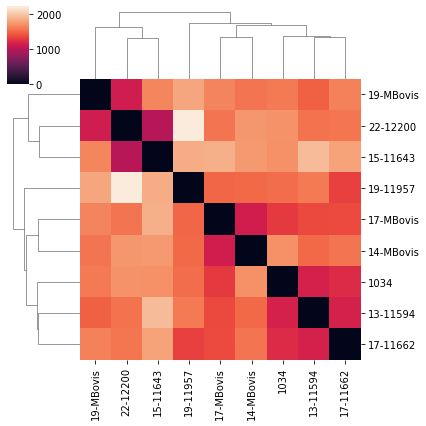

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="275.0px" viewBox="0 0 500.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tae723fc851044f1bbf7d27255c004c47"> 17-MBovis 14-MBovis 19-11957 22-12200 15-11643 19-MBovis 17-11662 1034 13-11594 0 310 619 929 1239

In [798]:
D = dist_matrix(profs)
D.to_csv('dist_mlst.csv',index=False)
sns.clustermap(D,xticklabels=True,yticklabels=True,figsize=(6,6))
tree_from_distmatrix(D)

tre = toytree.tree(treefile)
canvas,t,r=tre.draw(layout='r',scalebar=True,width=500)

/usr/local/lib/python3.9/dist-packages/seaborn/matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


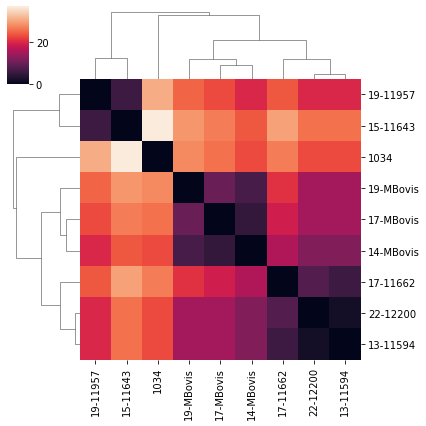

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="275.0px" viewBox="0 0 500.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t8cff1d088b09463f88b79274b6ff5500"> 13-11594 17-11662 22-12200 1034 19-11957 15-11643 19-MBovis 14-MBovis 17-MBovis 0 6 12 18 24

In [811]:
D = dist_matrix(profs1)
D.to_csv('dist_mlst.csv',index=False)
sns.clustermap(D,xticklabels=True,yticklabels=True,figsize=(6,6))
tree_from_distmatrix(D)

tre = toytree.tree(treefile)
canvas,t,r=tre.draw(layout='r',scalebar=True,width=500)

In [812]:
tre2 = toytree.tree('/storage/btbgenie/wicklow_results/RAxML_bestTree.variants')
drop = list(set(tre2.get_tip_labels()) - set(tre.get_tip_labels()))
drop+=['17-11662']
tre2=tre2.drop_tips(drop)
canvas,t,r=tre2.draw(layout='r',scalebar=True,width=800)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="275.0px" viewBox="0 0 800.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t9f0cfe4806b84af58056bfb2272d0837"> 19-11957 15-11643 14-MBovis 22-12200 19-MBovis 1034 13-11594 17-MBovis 0.000 0.005 0.010 0.015 0.019 0.024 0.029 0.034